In [ ]:
import sympy as sp
from quadjax.dynamics.dataclass import EnvParams3D, EnvState3D, Action3D
from quadjax.dynamics.utils import angle_normalize
from quadjax.dynamics import geom
from jax import numpy as jnp


def quat2rot(quat):
    x, y, z, w = quat
    return sp.Matrix([
        [1 - 2*y**2 - 2*z**2, 2*x*y - 2*w*z, 2*x*z + 2*w*y],
        [2*x*y + 2*w*z, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*w*x],
        [2*x*z - 2*w*y, 2*y*z + 2*w*x, 1 - 2*x**2 - 2*y**2]
    ])


# Define time variable
# define parameter symbols
g, m, mo, l = sp.symbols("g m mo l")
I = sp.Matrix(sp.symbols(
    'I_11 I_12 I_13 I_21 I_22 I_23 I_31 I_32 I_33')).reshape(3, 3)
hook_offset = sp.Matrix(sp.symbols(
    'hook_offset_x hook_offset_y hook_offset_z')).reshape(3, 1)
params = [g, m, mo, l, I[0, 0], I[0, 1], I[0, 2], I[1, 0], I[1, 1], I[1, 2],
          I[2, 0], I[2, 1], I[2, 2], hook_offset[0], hook_offset[1], hook_offset[2]]
# define dynamic state
pos = sp.Matrix(sp.symbols('pos_x pos_y pos_z')).reshape(3, 1)
vel = sp.Matrix(sp.symbols('vel_x vel_y vel_z')).reshape(3, 1)
quat = sp.Matrix(sp.symbols('quat_x quat_y quat_z quat_w')).reshape(4, 1)
omega = sp.Matrix(sp.symbols('omega_x omega_y omega_z')).reshape(3, 1)
theta_rope = sp.Symbol("theta_rope")
theta_rope_dot = sp.Symbol("theta_rope_dot")
phi_rope = sp.Symbol("phi_rope")
phi_rope_dot = sp.Symbol("phi_rope_dot")
states = [
    pos[0], pos[1], pos[2],
    vel[0], vel[1], vel[2],
    quat[0], quat[1], quat[2], quat[3],
    omega[0], omega[1], omega[2],
    theta_rope, theta_rope_dot, phi_rope, phi_rope_dot
]
# dynamic variables to solve
acc = sp.Matrix(sp.symbols('acc_x acc_y acc_z')).reshape(3, 1)
alpha = sp.Matrix(sp.symbols('alpha_x alpha_y alpha_z')).reshape(3, 1)
theta_rope_ddot = sp.Symbol("theta_rope_ddot")
phi_rope_ddot = sp.Symbol("phi_rope_ddot")
f_rope_norm = sp.Symbol("f_rope_norm")
states_dot = [
    acc[0, 0], acc[1, 0], acc[2, 0],
    alpha[0, 0], alpha[1, 0], alpha[2, 0],
    theta_rope_ddot, phi_rope_ddot, 
    f_rope_norm
]
# get other state variables
rotmat = quat2rot(quat)
hook_offset_world = rotmat @ hook_offset
pos_hook = pos + hook_offset_world
vel_hook = vel + sp.Matrix.cross(omega, hook_offset_world)
acc_hook = acc + sp.Matrix.cross(alpha, hook_offset_world) + sp.Matrix.cross(
    omega, sp.Matrix.cross(omega, hook_offset_world))
zeta = sp.Matrix([sp.sin(theta_rope) * sp.cos(phi_rope),
                  sp.sin(theta_rope) * sp.sin(phi_rope), sp.cos(theta_rope)])
zeta_dot = sp.Matrix([-sp.sin(theta_rope) * sp.sin(phi_rope) * theta_rope_dot + sp.cos(theta_rope) * sp.cos(phi_rope) * phi_rope_dot,
                      sp.sin(phi_rope) * sp.cos(theta_rope) * theta_rope_dot + sp.cos(phi_rope) * sp.sin(theta_rope) * phi_rope_dot, -sp.sin(theta_rope) * theta_rope_dot])
zeta_ddot = sp.Matrix([[-sp.sin(phi_rope)*sp.sin(theta_rope)*phi_rope_ddot - 2*sp.sin(phi_rope)*sp.cos(theta_rope)*phi_rope_dot*theta_rope_dot - sp.sin(theta_rope)*sp.cos(phi_rope)*phi_rope_dot**2 - sp.sin(theta_rope)*sp.cos(phi_rope)*theta_rope_dot**2 + sp.cos(phi_rope)*sp.cos(theta_rope)*theta_rope_ddot], [-sp.sin(phi_rope)*sp.sin(
    theta_rope)*phi_rope_dot**2 - sp.sin(phi_rope)*sp.sin(theta_rope)*theta_rope_dot**2 + sp.sin(phi_rope)*sp.cos(theta_rope)*theta_rope_ddot + sp.sin(theta_rope)*sp.cos(phi_rope)*phi_rope_ddot + 2*sp.cos(phi_rope)*sp.cos(theta_rope)*phi_rope_dot*theta_rope_dot], [-(sp.sin(theta_rope)*theta_rope_ddot + sp.cos(theta_rope)*theta_rope_dot**2)]])
pos_obj = pos_hook + l * zeta
vel_obj = vel_hook + l * zeta_dot
acc_obj = acc_hook + l * zeta_ddot
f_rope = f_rope_norm * zeta
# define action
thrust = sp.Symbol("thrust")
thrust_local = sp.Matrix([0, 0, thrust])
thrust_world = rotmat @ thrust_local
torque = sp.Matrix(sp.symbols('torque_x torque_y torque_z')).reshape(3, 1)
action = [thrust, torque[0], torque[1], torque[2]]

# newton's law (9 equations)
# quadrotor
eq_quad_pos = sp.Matrix([0, 0, -m*g]) + f_rope + thrust_world - m * acc
eq_quad_rot = torque + \
    sp.Matrix.cross(hook_offset_world, f_rope) - \
    sp.Matrix.cross(omega, I @ omega) - I @ alpha
# object
eq_obj_pos = -f_rope + sp.Matrix([0, 0, -mo*g]) - mo * acc_obj

# expand all equations
eqs = []
for eq in [eq_quad_pos, eq_quad_rot, eq_obj_pos]:
    for i in range(3):
        eqs.append(eq[i].expand())
unknowns = [acc[0], acc[1], acc[2], alpha[0], alpha[1],
            alpha[2], theta_rope_ddot, phi_rope_ddot, f_rope_norm]

# Solve for the acceleration
A_taut_dyn = sp.zeros(9, 9)
b_taut_dyn = sp.zeros(9, 1)
for i in range(9):
    for j in range(9):
        A_taut_dyn[i, j] = eqs[i].coeff(unknowns[j])
    b_taut_dyn[i] = -eqs[i].subs([(unknowns[j], 0) for j in range(9)])

# Define matrix function
A_taut_dyn_func = sp.lambdify(params + states + action, A_taut_dyn, "jax")
b_taut_dyn_func = sp.lambdify(params + states + action, b_taut_dyn, "jax")

# Define other dynamic variable functions
pos_hook_func = sp.lambdify(params + states + states_dot + action, pos_hook, "jax")
vel_hook_func = sp.lambdify(params + states + states_dot + action, vel_hook, "jax")
pos_obj_func = sp.lambdify(params + states + states_dot + action, pos_obj, "jax")
vel_obj_func = sp.lambdify(params + states + states_dot + action, vel_obj, "jax")
f_rope_func = sp.lambdify(params + states + states_dot + action, f_rope, "jax")
zeta_func = sp.lambdify(params + states + states_dot + action, zeta, "jax")
zeta_dot_func = sp.lambdify(params + states + states_dot + action, zeta_dot, "jax")

def taut_dynamics(env_params: EnvParams3D, env_state: EnvState3D, env_action: Action3D):
    params = [env_params.g, env_params.m, env_params.mo, env_params.l, env_params.I[0, 0], env_params.I[0, 1], env_params.I[0, 2], env_params.I[1, 0], env_params.I[1, 1], env_params.I[1, 2],
                env_params.I[2, 0], env_params.I[2, 1], env_params.I[2, 2], env_params.hook_offset[0], env_params.hook_offset[1], env_params.hook_offset[2]]
    states = [
        env_state.pos[0], env_state.pos[1], env_state.pos[2],
        env_state.vel[0], env_state.vel[1], env_state.vel[2],
        env_state.quat[0], env_state.quat[1], env_state.quat[2], env_state.quat[3],
        env_state.omega[0], env_state.omega[1], env_state.omega[2],
        env_state.theta_rope, env_state.theta_rope_dot, env_state.phi_rope, env_state.phi_rope_dot
    ]
    action = [env_action.thrust, env_action.torque[0], env_action.torque[1], env_action.torque[2]]
    A = A_taut_dyn_func(*params, *states, *action)
    b = b_taut_dyn_func(*params, *states, *action)
    states_dot = jnp.linalg.solve(A, b).squeeze()
    acc_x, acc_y, acc_z, alpha_x, alpha_y, alpha_z, theta_rope_ddot, phi_rope_ddot, f_rope_norm = states_dot
    acc = jnp.array([acc_x, acc_y, acc_z])
    alpha = jnp.array([alpha_x, alpha_y, alpha_z])

    # calculate updated state variables
    new_vel = env_state.vel + acc * env_params.dt
    new_pos = env_state.pos + new_vel * env_params.dt
    new_omega = env_state.omega + alpha * env_params.dt
    new_quat = geom.integrate_quat(env_state.quat, new_omega, env_params.dt)
    new_theta_rope_dot = env_state.theta_rope_dot + theta_rope_ddot * env_params.dt
    new_theta_rope = env_state.theta_rope + new_theta_rope_dot * env_params.dt
    new_phi_rope_dot = angle_normalize(env_state.phi_rope_dot + phi_rope_ddot * env_params.dt)
    new_phi_rope = angle_normalize(env_state.phi_rope + new_phi_rope_dot * env_params.dt)

    # Update states list
    states_new = [
        new_pos[0], new_pos[1], new_pos[2],
        new_vel[0], new_vel[1], new_vel[2],
        new_quat[0], new_quat[1], new_quat[2], new_quat[3],
        new_omega[0], new_omega[1], new_omega[2],
        new_theta_rope, new_theta_rope_dot, new_phi_rope, new_phi_rope_dot
    ]

    # Compute other state variables
    time = env_state.time + 1
    pos_tar = env_state.pos_traj[time]
    vel_tar = env_state.vel_traj[time]

    # replace state
    env_state.replace(
        pos=new_pos, vel=new_vel, quat=new_quat, omega=new_omega,
        theta_rope=new_theta_rope, theta_rope_dot=new_theta_rope_dot,
        phi_rope=new_phi_rope, phi_rope_dot=new_phi_rope_dot, 
        pos_tar = pos_tar, vel_tar = vel_tar, 
        pos_hook = pos_hook_func(*params, *states_new, *states_dot, *action),
        vel_hook = vel_hook_func(*params, *states_new, *states_dot, *action),
        pos_obj = pos_obj_func(*params, *states_new, *states_dot, *action),
        vel_obj = vel_obj_func(*params, *states_new, *states_dot, *action),
        f_rope_norm = f_rope_norm, 
        f_rope = f_rope_func(*params, *states_new, *states_dot, *action),
        l_rope = env_params.l,
        zeta = zeta_func(*params, *states_new, *states_dot, *action),
        zeta_dot = zeta_dot_func(*params, *states_new, *states_dot, *action),
        last_thrust = env_action.thrust,
        last_torque = env_action.torque,
        time = time
    )

In [ ]:
A_taut_dyn

In [ ]:
import numpy as np

A = np.eye(3)
A[0,1] = 1
A[2,2] = 0

# Moore-Penrose inverse of A
A_inv = np.linalg.pinv(A)
A_inv

In [1]:
from quadjax.dynamics.utils import generate_lissa_traj, generate_zigzag_traj
import jax

# RNG key
key = jax.random.PRNGKey(0)
jax.disable_jit()
# generate trajectory
pos_traj_lissa, vel_traj_lissa = generate_lissa_traj(300, 0.1, key)
pos_traj_zigzag, vel_traj_zigzag = generate_zigzag_traj(300, 0.1, key)

In [2]:
pos_traj_zigzag

Array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.91610456e-02, -4.41252962e-02, -1.81673765e-02],
       [-3.83220911e-02, -8.82505849e-02, -3.63347456e-02],
       [-5.74831367e-02, -1.32375881e-01, -5.45021147e-02],
       [-7.66441822e-02, -1.76501170e-01, -7.26694837e-02],
       [-9.58052278e-02, -2.20626459e-01, -9.08368528e-02],
       [-1.14966273e-01, -2.64751762e-01, -1.09004229e-01],
       [-1.34127319e-01, -3.08877051e-01, -1.27171606e-01],
       [-1.53288364e-01, -3.53002340e-01, -1.45338967e-01],
       [-1.72449410e-01, -3.97127628e-01, -1.63506344e-01],
       [-1.91610456e-01, -4.41252917e-01, -1.81673706e-01],
       [-2.10771501e-01, -4.85378206e-01, -1.99841082e-01],
       [-2.29932547e-01, -5.29503524e-01, -2.18008459e-01],
       [-2.49093592e-01, -5.73628843e-01, -2.36175835e-01],
       [-2.68254638e-01, -6.17754102e-01, -2.54343212e-01],
       [-2.87415683e-01, -6.61879361e-01, -2.72510588e-01],
       [-3.06576729e-01, -7.06004679e-01

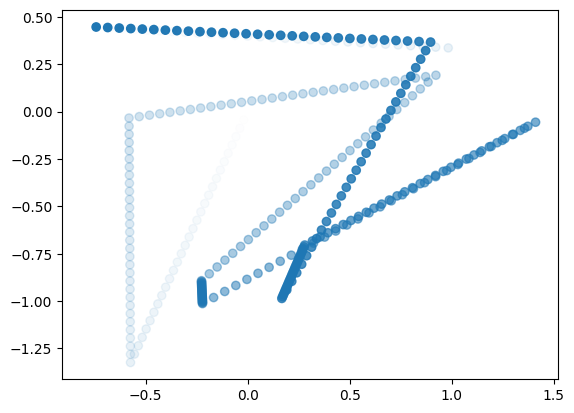

In [3]:
# plot all points in pos_traj_zigzag and mark different point with different alpha
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(pos_traj_zigzag[:, 0], pos_traj_zigzag[:, 1], alpha=np.linspace(0, 1, 300))